In [8]:
import os
import random

import pandas as pd
import numpy as np

In [9]:
SEQ_LEN=120
SPLIT=(0.6, 0.2, 0.2)

### Load data

In [10]:
data_path = 'dataset/demo/displacements/'

all_files = os.listdir(data_path)
games_inputs = {}
for filename in all_files:
    filepath = data_path + filename
    inputs = pd.read_csv(filepath)
    games_inputs[filename.split('.')[0]] = inputs

games_inputs[all_files[0].split('.')[0]].head(10)

,d_x,d_y,frames_elapsed
0,0.9875,0.0000,0.383333
1,0.0125,0.0000,0.050000
2,-0.0125,0.0000,0.166667
3,0.0125,0.0000,0.016667
4,-0.0125,0.0000,0.016667
5,-0.0125,0.0000,0.133333
6,-0.0125,0.0000,0.016667
7,-0.0375,0.3375,0.016667
8,-0.0250,0.0750,0.016667
9,-0.0250,0.0500,0.016667


### Organize by user (necessary for labelling)

In [11]:
def sort_games_by_user():
    users_sessions = {}
    for filename in all_files:
        user = filename.split('_')[0]

        if user not in users_sessions.keys():
            users_sessions[user] = []
        
        users_sessions[user].append(filename.split('.')[0])
    
    return users_sessions

games_by_player = sort_games_by_user()

inputs_by_player = {}

for player in games_by_player.keys():
    # get the inputs from all the games played by a certain player
    player_games_inputs = [games_inputs[game] for game in games_by_player[player]]
    player_inputs = pd.concat(player_games_inputs, ignore_index=True)
    
    inputs_by_player[player] = player_inputs

inputs_by_player['aklo'].shape

(128676, 3)

In [12]:
inputs_by_player.keys()

dict_keys(['axe', 'plup', 'kodorin', 'aklo', '2saint', 'mang0', 'n0ne', 'zain', 'hbox', 'moky', 'wizzrobe', 'sfat', 'amsa', 'cody', 'logan', 'cynthia', 'cpu', 'yingling'])

### Organize data into labelled sequences

In [13]:
players_set = list(inputs_by_player.keys())
players_set.sort() # ensure the mappings are the same every time

player_to_int = {key: i for i, key in enumerate(players_set)}
int_to_player = {i: key for key, i in player_to_int.items()}

def seqs_from_df(df, player_id, seq_len=100):
    seqs = []

    label = np.zeros(len(players_set))
    label[player_id] = 1.0

    for i in range(0, df.shape[0] - seq_len, int(seq_len*0.5)):
        seq_x = df.loc[i:i+seq_len-1]
        seqs.append((seq_x, label))
        
    return seqs

labelled_ml_data = [seqs_from_df(inputs_by_player[p], player_to_int[p], SEQ_LEN) for p in players_set]
labelled_ml_data = [seq for p in labelled_ml_data for seq in p] # flatten
random.shuffle(labelled_ml_data)
len(labelled_ml_data)

30607

In [14]:
int_to_player

{0: '2saint',
 1: 'aklo',
 2: 'amsa',
 3: 'axe',
 4: 'cody',
 5: 'cpu',
 6: 'cynthia',
 7: 'hbox',
 8: 'kodorin',
 9: 'logan',
 10: 'mang0',
 11: 'moky',
 12: 'n0ne',
 13: 'plup',
 14: 'sfat',
 15: 'wizzrobe',
 16: 'yingling',
 17: 'zain'}

### Split into training, validation, and test sets

In [15]:
def split_set(examples_list, split=SPLIT):
    split_indices = [0, 0, 0]
    for i in range(3):
        split_indices[i] = int(split[i] * len(examples_list))
        if i >= 1:
            split_indices[i] += split_indices[i-1]

    print(split_indices)
    
    return (examples_list[0:split_indices[0]], examples_list[split_indices[0]:split_indices[1]], examples_list[split_indices[1]:split_indices[2]])

train, valid, test = split_set(labelled_ml_data, (0.6, 0.2, 0.2))

print(f'{len(train)=}, {len(valid)=}, {len(test)=}, {len(labelled_ml_data)=}')

[18364, 24485, 30606]
len(train)=18364, len(valid)=6121, len(test)=6121, len(labelled_ml_data)=30607


In [16]:
train_x, train_y = (np.array([x.to_numpy(dtype=np.float32) for (x, _) in train], dtype=np.float32), np.array([y for (_, y) in train]))
valid_x, valid_y =(np.array([x.to_numpy(dtype=np.float32) for (x, _) in valid], dtype=np.float32), np.array([y for (_, y) in valid]))
test_x, test_y = (np.array([x.to_numpy(dtype=np.float32) for (x, _) in test], dtype=np.float32), np.array([y for (_, y) in test]))

print(f'{train_x[0]=}\n{train_x[0].shape= }, {(train_x.shape)=}\n')
print(f'\n{train_y[0]=}, {len(train_y)=}')

train_x[0]=array([[ 0.125     ,  0.17500001,  0.01666667],
       [ 0.01249999,  0.03749999,  0.01666667],
       [ 0.01250005,  0.01249999,  0.01666667],
       [-0.01250005,  0.        ,  0.05      ],
       [-0.04999995, -0.11249998,  0.01666667],
       [-0.33750004, -0.08750004,  0.03333334],
       [-0.5125    ,  0.6       ,  0.01666667],
       [ 0.9875    ,  0.        ,  0.05      ],
       [-0.01249999,  0.        ,  0.1       ],
       [-0.01250005,  0.        ,  0.03333334],
       [-1.95      ,  0.        ,  0.01666667],
       [-0.01249999,  0.        ,  0.11666667],
       [ 0.01249999,  0.        ,  0.01666667],
       [-0.01249999,  0.        ,  0.18333334],
       [ 0.01249999,  0.        ,  0.03333334],
       [ 0.625     ,  0.        ,  0.03333334],
       [ 1.3       , -0.3125    ,  0.01666667],
       [ 0.01249999,  0.01249999,  0.03333334],
       [-0.01249999, -0.01249999,  0.05      ],
       [ 0.        , -0.01249999,  0.05      ],
       [-0.02499998, -0.0625 

### Define the model

In [17]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, ELU, Dropout, Dense, Concatenate, Flatten, GRU, LSTM

2024-04-29 23:08:30.733993: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2024-04-29 23:08:32.121098: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:838] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-29 23:08:32.137383: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:838] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-29 23:08:32.137430: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:838] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-29 23:08:32.138442: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:838] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-29 23:08:32.138514: I tensorflow/compiler/xla/stream_executo

In [20]:
def createClassifier(width=3, seq_len=SEQ_LEN):
    input_layer = Input(shape=(seq_len, width))
    conv1 = Conv1D(filters=32, kernel_size=7, strides=2, activation=ELU())(input_layer)
    conv2 = Conv1D(filters=32, kernel_size=3, strides=1, activation=ELU())(input_layer)
    
    catted = Concatenate(axis=1)([conv1, conv2])
    elu1 = ELU(32)(catted)
    conv3 = Conv1D(filters=32, kernel_size=2, strides=1, activation=ELU())(elu1)
    conv4 = Conv1D(filters=32, kernel_size=2, strides=1, activation=ELU())(conv3)
    drop1 = Dropout(0.2)(conv4)

    lstm1 = LSTM(32, return_sequences=True)(drop1)
    lstm2 = LSTM(32)(lstm1)
    drop2 = Dropout(0.2)(lstm2)

    output = Dense(len(players_set), activation='softmax')(drop2)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = createClassifier(3)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 3)]             0         []                            
                                                                                                  
 conv1d_4 (Conv1D)           (None, 57, 32)               704       ['input_2[0][0]']             
                                                                                                  
 conv1d_5 (Conv1D)           (None, 118, 32)              320       ['input_2[0][0]']             
                                                                                                  
 concatenate_1 (Concatenate  (None, 175, 32)              0         ['conv1d_4[0][0]',            
 )                                                                   'conv1d_5[0][0]']      

In [21]:
history = model.fit(
    train_x, train_y, epochs=60, verbose=0, batch_size=64, validation_data=(valid_x, valid_y)
)

2024-04-29 23:09:09.699227: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-29 23:09:09.700938: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-29 23:09:09.709739: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-29 23:09:09.711172: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-29 23:09:09.724350: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-29 23:09:09.726334: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-29 23:09:09.736521: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-29 23:09:09.738469: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-29 23:09:09.744240: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-04-29 23:09:09

KeyboardInterrupt: 

In [17]:
import matplotlib.pyplot as plt

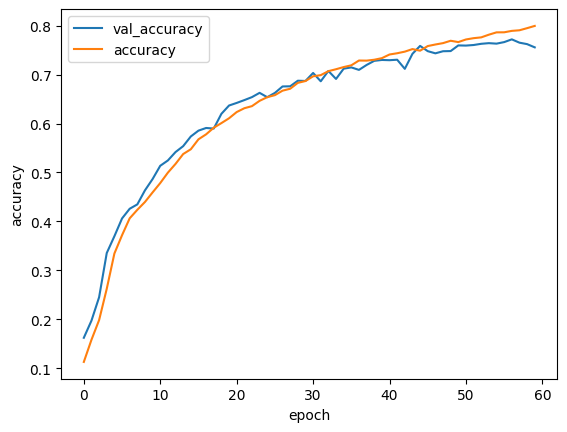

In [18]:
plt.plot('val_accuracy', data=history.history)
plt.plot('accuracy', data=history.history)
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend()

# plt.savefig('results/learning_curve')
plt.show()

## Example prediction

In [14]:
example_df = pd.read_csv('dataset/velocities/wizzrobe_sfat_18-07-21_16:09.csv', index_col=None)
predict = model(np.array([example_df.iloc[range(SEQ_LEN), :]], dtype=np.float32), training=False)

int_to_player[np.argmax(predict)]

'wizzrobe'

## Test the model

### Get test outputs

In [19]:
test_h = []
test_h = model.predict(test_x)

test_h.shape

190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


(6058, 16)

### Compare test outputs to labels

In [20]:
ranks = []

for i in range(test_h.shape[0]):
    rankings = np.argsort(test_h[i])
    rank = (len(players_set)-1) - np.where((rankings == np.argmax(test_y[i])))[0][0]
    ranks.append(rank)

topn_occurences = []
running = 0
for i in range(len(players_set)):
    topn_occurences.append(ranks.count(i) + running)
    running += ranks.count(i)

topn_acc = [t / topn_occurences[-1] for t in topn_occurences]

print(topn_acc)

[0.7743479696269396, 0.8935292175635523, 0.9405744470122153, 0.9610432485968967, 0.9768900627269727, 0.9859689666556619, 0.9899306701881809, 0.9935622317596566, 0.9958732254869594, 0.997358864311654, 0.9983492901947838, 0.9990095741168703, 0.9993397160779135, 1.0, 1.0, 1.0]
